<a href="https://colab.research.google.com/github/codingFerryman/crypto_market_hierarchy_structure/blob/main/src/30m_MST_per_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Focal time ranges: 2021/04/12-2021/06/14, 2021/08/16-2021/10/17

- Load data downloaded from Bitfinex.
- generate MST per day from the close price data at timescale 30 minutes.
- In each MST, set the top 5 coins with the largest degrees as leader coins. 
- Put the top 5 coins appearing most frequently as leader coins in the whole time range on the leader board. Set these coins and other selected coins as coins of interest.
- Plot the degree time series of coins of interest.
- Calculate MST node and edge similarities. Find the edges appearing most frequently in the MST series, and their node pairs, i.e. couple coins.
- Plot MST series. Fix the positions for all the coins, set the color of leader coins red, stable coins orange, and coins of interest green. Put coins of interest on special positions.
- Generate animation from MST series.

### Load Data

In [ ]:
import datetime
from pathlib import Path
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from utils import check_integrity, load_data, datestring_to_timestamp, get_golden_timestamps, my_fillna
import mplfinance as mpf
import numpy as np
import seaborn as sns
import networkx as nx
plt.rcParams.update({'font.size': 22})

In [ ]:
stable_coins = ['UST','PAX','DAI', 'MIM','TSD','UDC','EOSDT','XCH','EUS','XAUT']

In [ ]:
datelist1 = pd.date_range(start="2021-04-12",end="2021-06-14", periods = 64).tolist()
datelist1 = [datelist1[i].strftime('%Y-%m-%d') for i in range(len(datelist1))]
time_range1 = [(datelist1[i], datelist1[i+1]) for i in range(len(datelist1)-1)]
timestamp_range1 = [tuple(map(datestring_to_timestamp, tup)) for tup in time_range1]

datelist2 = pd.date_range(start="2021-08-16",end="2021-10-17", periods = 63).tolist()
datelist2 = [datelist2[i].strftime('%Y-%m-%d') for i in range(len(datelist2))]
time_range2 = [(datelist2[i], datelist2[i+1]) for i in range(len(datelist2)-1)]
timestamp_range2 = [tuple(map(datestring_to_timestamp, tup)) for tup in time_range2]

In [ ]:
data_dir = Path(os.getcwd(), '..', 'data').resolve()
intervals = ['30m'] # ['1D', '1h', '30m']
coins_pass_check = {}

for interval in intervals:
    coins_pass_check[interval] = []
    data_interval_dir = Path(data_dir, interval)
    files_path_list = [p for p in data_interval_dir.iterdir() if p.suffix == '.csv']
    for file_path in files_path_list:
        coin_code = file_path.name.split("_")[0]
        #if check_integrity(*time_ranges[0], file_path) is not None: # this is the old check_integrity, see updates in 'utils.py'
        coins_pass_check[interval].append(coin_code)

In [ ]:
def check_integrity_score_and_load_data(time_range, coins_pass_pre_check, score_threshold, check_intervals=['30m']):
    _coins_integrity = {}
    _coins_in_use = {}
    for _interval in check_intervals:
        _coins_integrity[_interval] = {}
        _coins_in_use[_interval] = {}
        _data_interval_dir = Path(data_dir, _interval)
        for i in time_range: 
            _coins_integrity[_interval][i] = {}
            _coins_in_use[_interval][i] = {}
            _coins_in_use[_interval][i]['data'] = {}
            _coins_in_use[_interval][i]['coin_list'] = None
            _temp_coins_in_use = []
            _temp_coins_in_use_list = []
            for _coin in coins_pass_pre_check['30m']:
                _file_path = Path(_data_interval_dir, f"{_coin}_USD_{_interval}.csv")                
                _c_df = load_data(i[0], i[1], _file_path, fill_na=True)
                if len(_c_df):
                    _coins_integrity[_interval][i][_coin] = len(_c_df[_c_df.is_fill == False]) / len(_c_df)
                    if _coins_integrity[_interval][i][_coin] >= score_threshold:
                        _temp_coins_in_use.append(_c_df)
                        _temp_coins_in_use_list.append(_coin)
                else: 
                    _coins_integrity[_interval][i][_coin] = None
            _coins_in_use[_interval][i]['data'] = pd.concat(_temp_coins_in_use)
            _coins_in_use[_interval][i]['coin_list'] = _temp_coins_in_use_list                            
    return _coins_integrity, _coins_in_use

In [ ]:
integrity_score_range1, coins_in_use_range1 = check_integrity_score_and_load_data(timestamp_range1, coins_pass_check, 0.4)

In [ ]:
integrity_score_range2, coins_in_use_range2 = check_integrity_score_and_load_data(timestamp_range2, coins_pass_check, 0.4)

### Generate MST

In [ ]:
# correlation matrix of percentage change of returns of close price
def close_pcr_cm(df, coin_list):
    _tmp_df_pcr_list = []
    for tick in coin_list:
        _tmp_df = df[df.index.get_level_values('coin') == tick].set_index('datetime').copy()['close'].rename(f'{tick}')        
        _tmp_df_pcr = _tmp_df.pct_change().fillna(0)
        _tmp_df_pcr_list.append(_tmp_df_pcr)
    _tmp_pcr_df = pd.concat(_tmp_df_pcr_list, axis=1)
    _tmp_pcr_df_cm = _tmp_pcr_df.corr(method='pearson')
    return _tmp_pcr_df_cm

In [ ]:
cm_pcr_range1 = {}
for i in timestamp_range1:
    df = coins_in_use_range1['30m'][i]['data']
    coin_list_range1 = coins_in_use_range1['30m'][i]['coin_list']
    cm_pcr_range1[i] = close_pcr_cm(df, coin_list_range1)    

In [ ]:
cm_pcr_range2 = {}
for i in timestamp_range2:
    df = coins_in_use_range2['30m'][i]['data']
    coin_list_range2 = coins_in_use_range2['30m'][i]['coin_list']
    cm_pcr_range2[i] = close_pcr_cm(df, coin_list_range2)  

In [ ]:
# generate MST from correlation matrix
def MST_from_cm_pcr(cmpcr):
    
    def MST(corr_mat):
        _dist_mx = np.sqrt(2*(1-corr_mat))
        _G = nx.from_numpy_matrix(_dist_mx)
        _M = nx.minimum_spanning_tree(_G,weight='weight')
        return _M

    _MST = MST(cmpcr.to_numpy())
    _tickers_list = list(cmpcr.columns)
    _tickers = {i:list(cmpcr.columns)[i] for i in range(len(list(cmpcr.columns)))}
    # add node attributes: leader, stable, coin_of_interest
    _attr_leader = {i:False for i in range(len(list(cmpcr.columns)))}
    _attr_stable = {i:False for i in range(len(list(cmpcr.columns)))}
    _attr_coin_of_interest = {i:False for i in range(len(list(cmpcr.columns)))}
    nx.set_node_attributes(_MST, values=_tickers, name='ticker')
    nx.set_node_attributes(_MST, values=_attr_leader, name='leader')
    nx.set_node_attributes(_MST, values=_attr_stable, name='stable')
    nx.set_node_attributes(_MST, values=_attr_coin_of_interest, name='coin_of_interest')
    return _MST, _tickers_list, _tickers

In [ ]:
# set node attributes: leader, stable, coin_of_interest
def target_coins(G, coin_of_interest):
    _MST = G[0]
    _tickers_list = G[1]
    _tickers = G[2]
    _coi = coin_of_interest

    # leader coins: top 5 coins with the largest degrees
    def topN(N, G):
        _degree = np.array([d for n, d in G.degree()])
        _top_indx = np.argsort(_degree)[-N:]
        _top_degree_ticker = [(G.nodes[i]['ticker'], G.degree(i)) for i in _top_indx[::-1]]
        _node_top_degree_ticker = [_tickers_list.index(i[0]) for i in _top_degree_ticker]                
        return _node_top_degree_ticker, _top_degree_ticker 
    _leader_coins = topN(5, _MST)
        
    # stable coins
    _node_stable_coins = [_tickers_list.index(i) for i in stable_coins if i in _tickers_list]
    _stable_coins = [(_MST.nodes[i]['ticker'], _MST.degree(i)) for i in _node_stable_coins]  
    # coins of interest, manually select
    _node_coin_of_interest = [_tickers_list.index(i) for i in _coi]
    _coin_of_interest = [(_MST.nodes[i]['ticker'], _MST.degree[i]) for i in _node_coin_of_interest]
    
    for i in range(len(_tickers_list)):
        if i in _node_stable_coins: 
            _MST.nodes[i]['color'] = 'orange'
            _MST.nodes[i]['stable'] = True
        elif i in _leader_coins[0]: 
            _MST.nodes[i]['color'] = 'red'
            _MST.nodes[i]['leader'] = True
        elif i in _node_coin_of_interest: 
            _MST.nodes[i]['color'] = 'green'
            _MST.nodes[i]['coin_of_interest'] = True
        else: _MST.nodes[i]['color'] = 'lightblue'
            
    return _MST, _tickers, _leader_coins[1], _stable_coins, _coin_of_interest

In [ ]:
MST_range1 = {}
for i in range(len(time_range1)):
    MST_range1[time_range1[i]] = {}
    MST_range1[time_range1[i]]['raw'] = MST_from_cm_pcr(cm_pcr_range1[timestamp_range1[i]])
    MST_range1[time_range1[i]]['target'] = target_coins(MST_range1[time_range1[i]]['raw'], ['BTC'])

In [ ]:
MST_range2 = {}
for i in range(len(time_range2)):
    MST_range2[time_range2[i]] = {}
    MST_range2[time_range2[i]]['raw'] = MST_from_cm_pcr(cm_pcr_range2[timestamp_range2[i]])
    MST_range2[time_range2[i]]['target'] = target_coins(MST_range2[time_range2[i]]['raw'], ['BTC'])

### Build Leader Board

In [ ]:
# MST[2] = leader_coins, MST[3] = stable_coins, MST[4] = coin_of_interest
MST_range1[time_range1[55]]['target'][2]

[('BTC', 9), ('BAND', 6), ('LINK', 5), ('TRX', 5), ('ETH', 5)]

In [ ]:
# select coins most frequently appear as leader coins
def leader_board(time_range, MST_range):
    _leaders = {}
    _tr = time_range
    _Mr = MST_range
    for i in range(len(_tr)):
        _leaders[_tr[i]] = _Mr[_tr[i]]['target'][2]
    _leader_freq = {}
    for day, leaders_of_day in _leaders.items():
        for tic in leaders_of_day:
            if tic[0] in _leader_freq.keys(): _leader_freq[tic[0]] += 1
            else: _leader_freq[tic[0]] = 1  
    _leader_freq_sorted = list(sorted(_leader_freq.items(), key=lambda item: item[1]))
    _top = _leader_freq_sorted[-5:]
    _top_tic = [i[0] for i in _top]
    return _top, _top_tic

In [ ]:
leader_board_range1 = leader_board(time_range1, MST_range1)
leader_board_range1

([('EOS', 14), ('NEO', 16), ('LINK', 18), ('ETH', 35), ('TRX', 39)],
 ['EOS', 'NEO', 'LINK', 'ETH', 'TRX'])

In [ ]:
leader_board_range2 = leader_board(time_range2, MST_range2)
leader_board_range2

([('TRX', 16), ('BTC', 17), ('NEO', 18), ('ETH', 27), ('EOS', 33)],
 ['TRX', 'BTC', 'NEO', 'ETH', 'EOS'])

### Select Coins of Interest

In [ ]:
coin_of_interest_range1 = leader_board_range1[1].copy()
if 'BTC' not in coin_of_interest_range1: coin_of_interest_range1.append('BTC')
coin_of_interest_range2 = leader_board_range2[1].copy()
if 'BTC' not in coin_of_interest_range2: coin_of_interest_range2.append('BTC')
for i in range(len(time_range1)):
    MST_range1[time_range1[i]]['target_leader'] = target_coins(MST_range1[time_range1[i]]['raw'], coin_of_interest_range1)
for i in range(len(time_range2)):
    MST_range2[time_range2[i]]['target_leader'] = target_coins(MST_range2[time_range2[i]]['raw'], coin_of_interest_range2)    

In [ ]:
# degree time series of coins of interest
def coi_degree_ts(time_range, MST_range, coi_range):
    _tr = time_range
    _Mr = MST_range
    _cr = coi_range
    _coi_d = {}
    for i in range(len(_tr)):
        _coi_d[_tr[i]] = _Mr[_tr[i]]['target_leader'][4]
    _coi_d_df = {}
    for i in _cr:
        _coi_d_df[i] = []
    for i in range(len(_tr)):
        for j in range(len(_cr)):
            _coi_d_df[_cr[j]].append(_coi_d[_tr[i]][j][1])
    _coi_df = pd.DataFrame.from_dict(_coi_d_df)        
    return _coi_df

In [ ]:
coi_d_ts1 = coi_degree_ts(time_range1, MST_range1, coin_of_interest_range1)
coi_d_ts2 = coi_degree_ts(time_range2, MST_range2, coin_of_interest_range2)

In [ ]:
%matplotlib inline
def plot_coi_d_ts(coi_d_ts):    
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    _col = coi_d_ts.columns
    for i in range(len(_col)):
        ax = axs.reshape(-1)[i]
        ax.plot(coi_d_ts[_col[i]], label=_col[i])
        ax.legend()

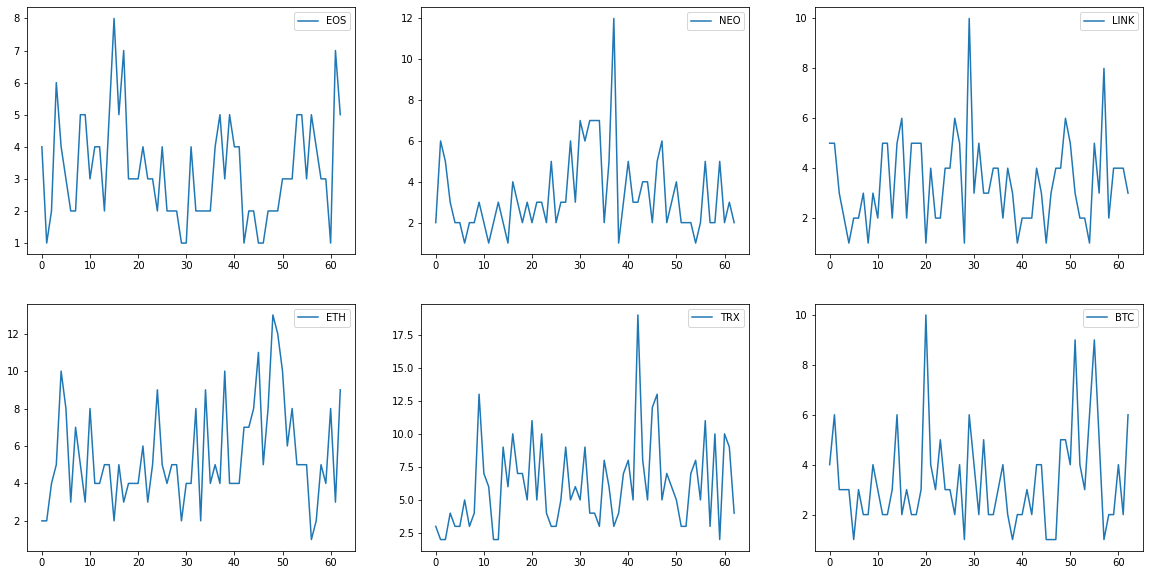

In [ ]:
plot_coi_d_ts(coi_d_ts1)

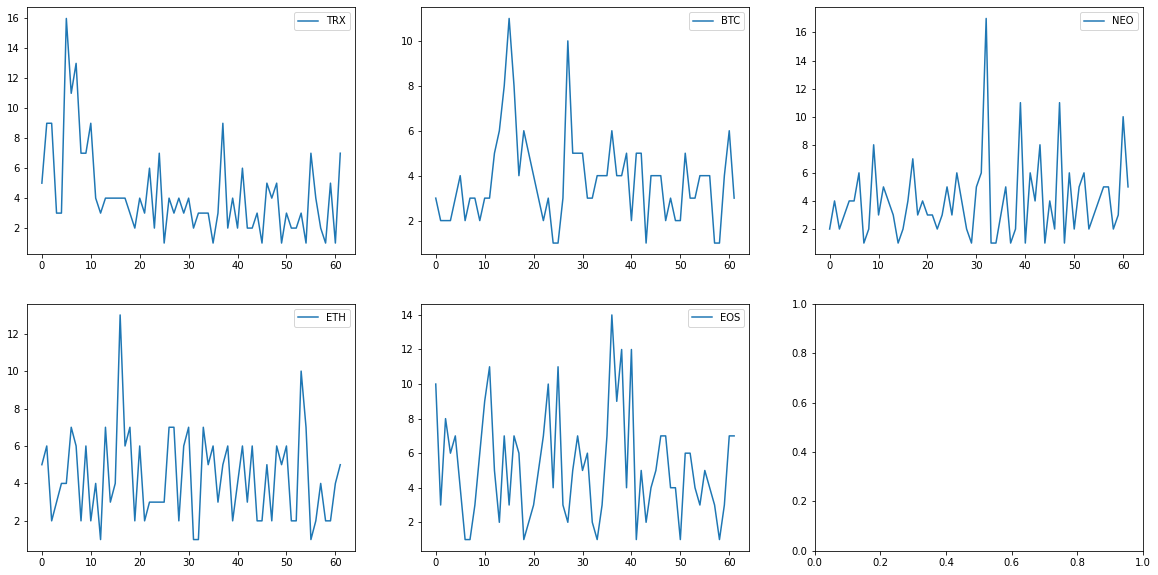

In [ ]:
plot_coi_d_ts(coi_d_ts2)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

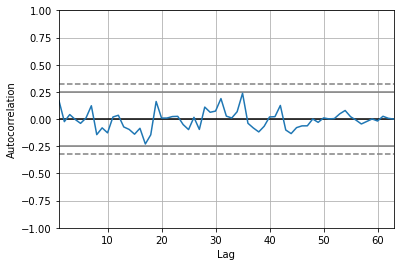

In [ ]:
pd.plotting.autocorrelation_plot(coi_d_ts1['BTC'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

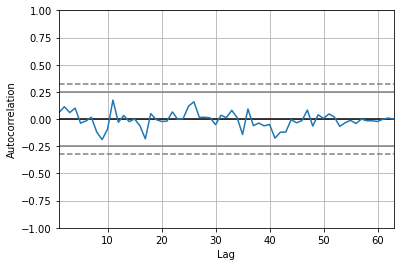

In [ ]:
pd.plotting.autocorrelation_plot(coi_d_ts1['TRX'])

### Calculate MST Node and Edge Similarity

In [ ]:
def jaccard_similarity(g, h):
    _intersec = set(g).intersection(set(h))
    _union = set(g).union(set(h))
    return float(len(_intersec)/len(_union)), _intersec

In [ ]:
def node_index_to_ticker(MST_range):
    _MST_E = MST_range[0].edges
    _tic = MST_range[1]
    _MST_E_tic = []
    for i in range(len(_MST_E)):
        _e = list(_MST_E(i))[0]
        _et = tuple([_tic[i] for i in _e])
        # also include reversed node pairs
        _etr = tuple((_et[1], _et[0]))
        _MST_E_tic.append(_et)
        _MST_E_tic.append(_etr)
    return _MST_E_tic    

In [ ]:
MST_node_sim_range1 = []
for i in range(len(time_range1)-1):
    mstn0 = MST_range1[time_range1[i]]['target_leader'][1].values()
    mstn1 = MST_range1[time_range1[i+1]]['target_leader'][1].values()
    MST_node_sim_range1.append(jaccard_similarity(mstn0, mstn1))
MST_node_sim_range2 = []
for i in range(len(time_range2)-1):
    mstn0 = MST_range2[time_range2[i]]['target_leader'][1].values()
    mstn1 = MST_range2[time_range2[i+1]]['target_leader'][1].values()
    MST_node_sim_range2.append(jaccard_similarity(mstn0, mstn1))

In [ ]:
MST_edge_sim_range1 = {'intersection':[], 'similarity':[]}
for i in range(len(time_range1)-1):
    mste0 = node_index_to_ticker(MST_range1[time_range1[i]]['target_leader'])
    mste1 = node_index_to_ticker(MST_range1[time_range1[i+1]]['target_leader'])
    sim, inter = jaccard_similarity(mste0, mste1)
    MST_edge_sim_range1['intersection'].append(inter)
    MST_edge_sim_range1['similarity'].append(sim)
MST_edge_sim_range2 = {'intersection':[], 'similarity':[]}
for i in range(len(time_range2)-1):
    mste0 = node_index_to_ticker(MST_range2[time_range2[i]]['target_leader'])
    mste1 = node_index_to_ticker(MST_range2[time_range2[i+1]]['target_leader'])
    sim, inter = jaccard_similarity(mste0, mste1)
    MST_edge_sim_range2['intersection'].append(inter)
    MST_edge_sim_range2['similarity'].append(sim)

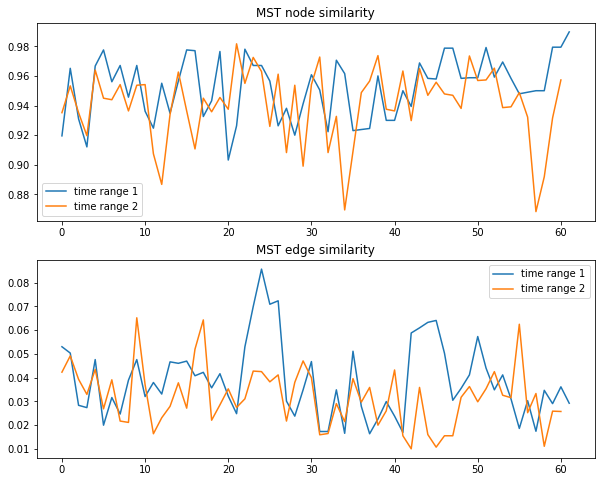

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
ax[0].set_title('MST node similarity')
ax[0].plot(MST_node_sim_range1, label='time range 1')
ax[0].plot(MST_node_sim_range2, label='time range 2')
ax[0].legend()
ax[1].set_title('MST edge similarity')
ax[1].plot(MST_edge_sim_range1['similarity'], label='time range 1')
ax[1].plot(MST_edge_sim_range2['similarity'], label='time range 2')
ax[1].legend()
plt.savefig('similarity.png')
plt.show()

In [ ]:
# find edges appearing most frequently in consecutive MST
from collections import Counter 
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(10)
edge_intersection_range1 = []
for intersec in MST_edge_sim_range1['intersection']:
    edge_intersection_range1.extend(list(intersec))
edge_intersection_range2 = []
for intersec in MST_edge_sim_range2['intersection']:
    edge_intersection_range2.extend(list(intersec))

In [ ]:
most_frequent(edge_intersection_range1)

[(('TRX', 'JST'), 28),
 (('JST', 'TRX'), 28),
 (('ETH', 'SUSHI'), 18),
 (('BAL', 'ETH'), 18),
 (('SUSHI', 'ETH'), 18),
 (('ETH', 'BAL'), 18),
 (('ETH', 'BTC'), 14),
 (('BTC', 'ETH'), 14),
 (('BTT', 'TRX'), 9),
 (('TRX', 'BTT'), 9)]

In [ ]:
most_frequent(edge_intersection_range2)

[(('BTC', 'WBT'), 24),
 (('WBT', 'BTC'), 24),
 (('ETH', 'BTC'), 22),
 (('BTC', 'ETH'), 22),
 (('TRX', 'SUN'), 15),
 (('SUN', 'TRX'), 15),
 (('TRX', 'JST'), 11),
 (('JST', 'TRX'), 11),
 (('EOS', 'LTC'), 9),
 (('LTC', 'EOS'), 9)]

### MST Series Plot

In [ ]:
# Get coin position dict from the MST with most nodes
def find_most_num_tickers(MST_range, time_range):
    _num_tickers = 0
    _index = 0
    for i in range(len(time_range)):    
        _len_tickers = len(MST_range[time_range[i]]['target_leader'][1].keys())
        if _len_tickers > _num_tickers : 
                _num_tickers = _len_tickers
                _index = i
    return _index, _num_tickers
indx_MST_most_nodes, num_most_nodes = find_most_num_tickers(MST_range1, time_range1) 
fixed_all_pos = nx.spring_layout(MST_range1[time_range1[indx_MST_most_nodes]]['target_leader'][0])
ticker_MST_most_nodes = MST_range1[time_range1[indx_MST_most_nodes]]['target_leader'][1]
fixed_all_pos_by_ticker = {}
for i in range(num_most_nodes):
    fixed_all_pos_by_ticker[ticker_MST_most_nodes[i]] = fixed_all_pos[i]         

In [ ]:
fixed_all_pos_by_ticker['BTC'] 

array([0.21429098, 0.43295168])

In [ ]:
# set positions for all nodes and put coins of interest on a circle
def get_coordinates_in_circle(n):
    thetas = [2*np.pi*(float(i)/n) for i in range(n)]
    return [(0.3*np.cos(theta),0.3*np.sin(theta)) for theta in thetas]
circular_positions = get_coordinates_in_circle(10)     

def MST_set_node_position(M, coi, circular, fixed_all_pos_by_ticker):
    _graph = M[0]
    _tickers = M[1]
    _coi = coi
    _cirp = circular
    _pos = {}
    _fapbt = fixed_all_pos_by_ticker     
    _fixed_nodes = []
    for i in _graph.nodes():
        try:
            _pos[i] = _fapbt[_graph.nodes[i]['ticker']]
        except KeyError:
            _pos[i] = tuple((_pos[i-1][0]+0.08,_pos[i-1][0]+0.08))
        for j in range(len(_coi)):
            if _graph.nodes[i]['ticker'] == _coi[j]:
                _pos[i] = _cirp[j]                    
    _large_nodes = [i for i in _graph.nodes() if _graph.nodes[i]['ticker'] in _coi or _graph.nodes[i]['leader']==True]
    _nodesize = [20]*len(_graph.nodes())
    for i in _large_nodes:
        _nodesize[i] = 40     
    return _graph, _pos, _nodesize, _tickers

In [ ]:
def plot_MST_series(i, MST_range, time_range, coin_of_interest_range):
    new_position = MST_set_node_position(MST_range[time_range[i]]['target_leader'], coin_of_interest_range, circular_positions, fixed_all_pos_by_ticker)
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    ax.axis('equal')
    fig.text(0.8, 0.7, f'{time_range[i][0]}',fontsize = 20)
    G = new_position[0]
    pos = new_position[1]
    nodesize = new_position[2]
    tickers = new_position[3]

    nx.draw(G, pos=pos, with_labels=True, labels=tickers,
                node_size=nodesize, font_size=10, edge_color='lightgray',
                node_color = [G.nodes[i]['color'] for i in G.nodes()],
                verticalalignment='bottom',alpha=1,ax=ax)
    plt.savefig(f'{i}.png')

In [ ]:
# in case some nodes overlap, manually adjust their positions
SAN_pos = fixed_all_pos_by_ticker['SAN']
fixed_all_pos_by_ticker['SAN'] = tuple((SAN_pos[0]-0.3, SAN_pos[1]-0.3))
fixed_all_pos_by_ticker['OCEAN'] = tuple((fixed_all_pos_by_ticker['BAT'][0]-0.1,fixed_all_pos_by_ticker['BAT'][1]))

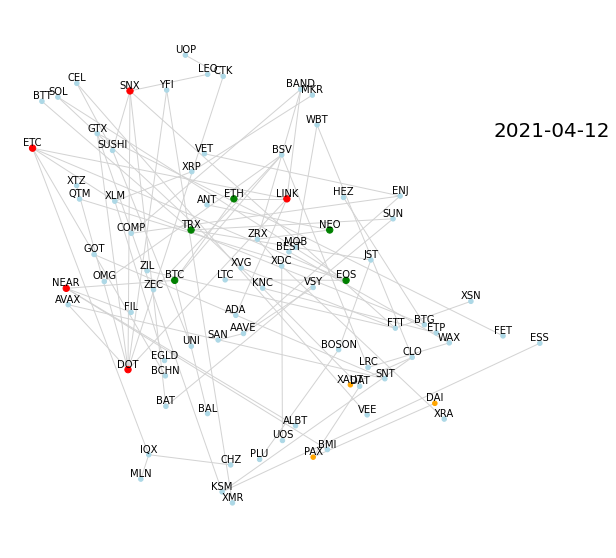

In [ ]:
plot_MST_series(0, MST_range1, time_range1, coin_of_interest_range1)

In [ ]:
# generate MST.png series
for i in range(0,62):
    plot_MST_series(i, MST_range1, time_range1, coin_of_interest_range1)
# Use MatLab to generate .gif from .png series, see sript 'MST_series_gif.m'